In [58]:
import numpy as np
from tqdm import tqdm 
import torch
import numpy as np
import random
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("D:\\1st\\BPs_BPTK\\Python") 
from BPS_init_function_MultiParas import BPS_BPTK_MultiParas
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
from sklearn.metrics import r2_score
import scipy.stats as stats
import os
os.chdir('d:\\1st\\BPs_BPTK')

In [66]:
X =  np.load("Python\optim\Time_DualNN14\database\input_add.npy")  

y = np.load("Python\optim\Time_DualNN14\database\label_add.npy")  


def standard_transform(x):
    # 计算每个特征的均值
    mean = x.mean(dim=0)
    # 计算每个特征的标准差
    std = x.std(dim=0, unbiased=False)  # unbiased=False 相当于 numpy 的 ddof=0
    # 避免使用0的标准差
    std[std == 0] = 1
    # 进行标准化转换
    x = (x - mean) / std
    return x,mean,std

def standard_transform_paras(x,mean,std):
    
    x = (x - mean) / std
    return x


def inverse_transform(x, mean, std):
    # 将标准化后的张量乘以标准差，然后加上均值
    x = x * std + mean
    return x




X = torch.tensor(X).float()
y = torch.tensor(y).float()


X,X_mean,X_std = standard_transform(X)
y,y_mean,y_std = standard_transform(y)

In [60]:
true_input1= torch.tensor([1.5645,
5.4775,
14.9545,
20.1718,
31.1918,
33.6998,
36.7238,
38.2173,
44.0313,
46.5051,
55.9614,
57.7614,
59.9664,
62.4556
]).float()*0.01

true_input2 = torch.tensor([4.433333333,
8.333333333,
13.1,
14.6,
22.45,
25.35,
27.66666667,
30.38333333,
33.96666667,
36.95,
46.33333333,
49.95,
#54.46666667,
59.35,
#61.91666667,
70.1,
#73.58333333
]).float()*200

true_input = torch.cat((true_input1,true_input2)).reshape(1,-1)

print(true_input)



true_input_transformed = standard_transform_paras(true_input,X_mean,X_std)



tensor([[1.5645e-02, 5.4775e-02, 1.4954e-01, 2.0172e-01, 3.1192e-01, 3.3700e-01,
         3.6724e-01, 3.8217e-01, 4.4031e-01, 4.6505e-01, 5.5961e-01, 5.7761e-01,
         5.9966e-01, 6.2456e-01, 8.8667e+02, 1.6667e+03, 2.6200e+03, 2.9200e+03,
         4.4900e+03, 5.0700e+03, 5.5333e+03, 6.0767e+03, 6.7933e+03, 7.3900e+03,
         9.2667e+03, 9.9900e+03, 1.1870e+04, 1.4020e+04]])


In [67]:
class ResNetBlock(nn.Module):
    def __init__(self, hyperparas):
        super(ResNetBlock, self).__init__()
        
        self.hidden_dim = hyperparas['hidden_dim']
        self.block_layer_nums =hyperparas['block_layer_nums']
            
        # Define layers for the function f (MLP)
        self.layers = nn.ModuleList()
        
        for _ in range(self.block_layer_nums - 1):  # -2 because we already added one layer and last layer is already defined
            self.layers.append(nn.Linear(self.hidden_dim,self.hidden_dim ))
        
        # Layer normalization
        self.layernorms = nn.ModuleList()
        for _ in range(self.block_layer_nums - 1):  # -1 because layer normalization is not applied to the last layer
            self.layernorms.append(nn.LayerNorm(self.hidden_dim))
        
    def forward(self, x):
        # Forward pass through the function f (MLP)
        out = x
        for i in range(self.block_layer_nums - 1):  # -1 because last layer is already applied outside the loop
            out = self.layers[i](out)
            out = self.layernorms[i](out)
            out = torch.relu(out)
        
        # Element-wise addition of input x and output of function f(x)
        out = x + out
        
        return out
    

class CustomResNN(nn.Module):
    def __init__(self,hyperparas):
        super().__init__()
        self.input_dim = hyperparas['input_dim'] #68
        self.hidden_dim = hyperparas['hidden_dim'] #30
        self.hidden_nums = hyperparas['hidden_nums'] #3
        self.output_dim = hyperparas['output_dim'] #3
        self.block_layer_nums = hyperparas['block_layer_nums'] #3

        self.layer_list = []
        self.layer_list.append(nn.Sequential(nn.Linear(self.input_dim,self.hidden_dim),nn.ReLU() ) )

        for _ in range(self.hidden_nums-1):
            self.layer_list.append(ResNetBlock(hyperparas))

        self.layer_list.append(nn.Linear(self.hidden_dim,self.output_dim))

        self.linear_Res_final = nn.Sequential(*self.layer_list)

    def forward(self,inputs):
        
        return self.linear_Res_final(inputs)

#超参数合集
hyperparas_reverse = {'input_dim':28,'hidden_dim':40,'hidden_nums':4,'output_dim':3,'block_layer_nums':3}
learning_rate = 0.001
num_epochs = 300

bestmodel = CustomResNN(hyperparas_reverse)
best_model_path ='Python\optim\Temporary_Model\model_best.pth'

best_model_path ='Python\optim\Settled_Model\DualTime14\model1.pth'


bestmodel.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [68]:
output = bestmodel(true_input_transformed)

output_inverse = inverse_transform(output,y_mean,y_std)

print(output_inverse)

tensor([[14.9206,  6.3745,  3.7023]], grad_fn=<AddBackward0>)


In [69]:
output_final = output_inverse.detach().numpy()

id = 0
time = np.arange(0,75,0.005)
_,urine,urineg =BPS_BPTK_MultiParas(t = time,volunteer_ID =id, paras = output_final,mode = '63')
urine_total = urine + urineg


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


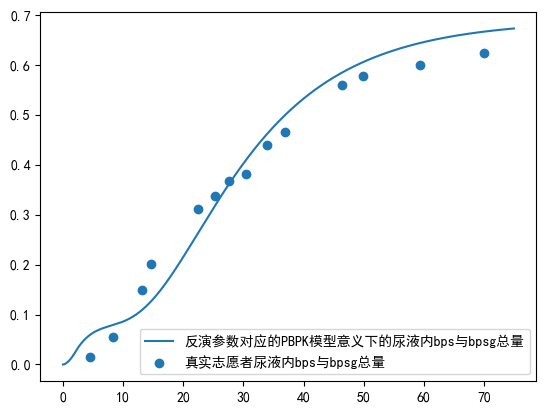

In [70]:
plt.plot(time,urine_total[0,:],label='反演参数对应的PBPK模型意义下的尿液内bps与bpsg总量')
plt.scatter(true_input2/200, true_input1, label='真实志愿者尿液内bps与bpsg总量')

plt.legend()
plt.show()

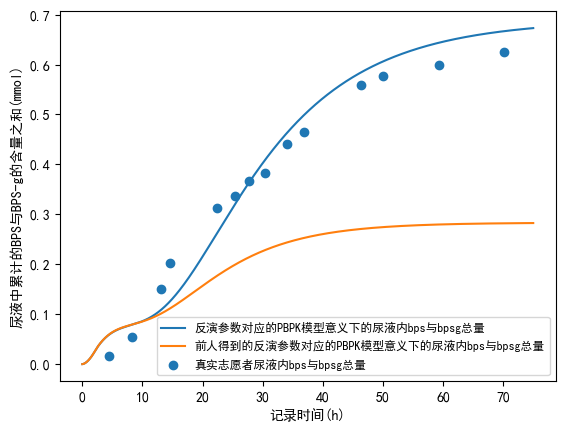

In [71]:
original_result = np.loadtxt (open("R\OriginalResult.csv"),delimiter=",",skiprows=1,usecols=range(2,65))

R_urine = original_result[:,38]
R_urineg = original_result[:,54]

R_urine_total = R_urine+R_urineg

plt.plot(time,urine_total[0,:],label='反演参数对应的PBPK模型意义下的尿液内bps与bpsg总量')
plt.plot(time,R_urine_total[0:15000],label='前人得到的反演参数对应的PBPK模型意义下的尿液内bps与bpsg总量')
plt.scatter(true_input2/200, true_input1, label='真实志愿者尿液内bps与bpsg总量')
plt.xlabel('记录时间(h)')
plt.ylabel('尿液中累计的BPS与BPS-g的含量之和(mmol)')
plt.legend(fontsize=8.6)

plt.show()